# OPERATIONS

# Importing libraries and datasets

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/Data Science for Business Package/4. Operations Department/4.Operations-Department.zip'
extract_dir = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/Data Science for Business Package/4. Operations Department/Data Folder'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print('Extraction complete.')


Extraction complete.


In [4]:
X_Ray_Directory = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/Data Science for Business Package/4. Operations Department/Data Folder/4. Operations Department/Dataset'

In [5]:
os.listdir(X_Ray_Directory)

['0', '1', '2', '3']

In [6]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [7]:
train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                      directory = X_Ray_Directory,
                                                      shuffle = True,
                                                      target_size = (256, 256),
                                                      class_mode = 'categorical',
                                                      subset = 'training')

Found 428 images belonging to 4 classes.


In [8]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                      directory = X_Ray_Directory,
                                                      shuffle = True,
                                                      target_size = (256, 256),
                                                      class_mode = 'categorical',
                                                      subset = 'validation')

Found 104 images belonging to 4 classes.


In [9]:
train_images, train_labels = next(train_generator)

In [10]:
train_images.shape

(40, 256, 256, 3)

In [11]:
train_labels.shape

(40, 4)

In [12]:
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]],

In [13]:
label_names = { 0 :'Covid-19',
                1 : 'Normal',
                2 : 'Viral Pneumonia',
                3 : 'Bacterial Pneumonia'}

# Visualizing the Dataset

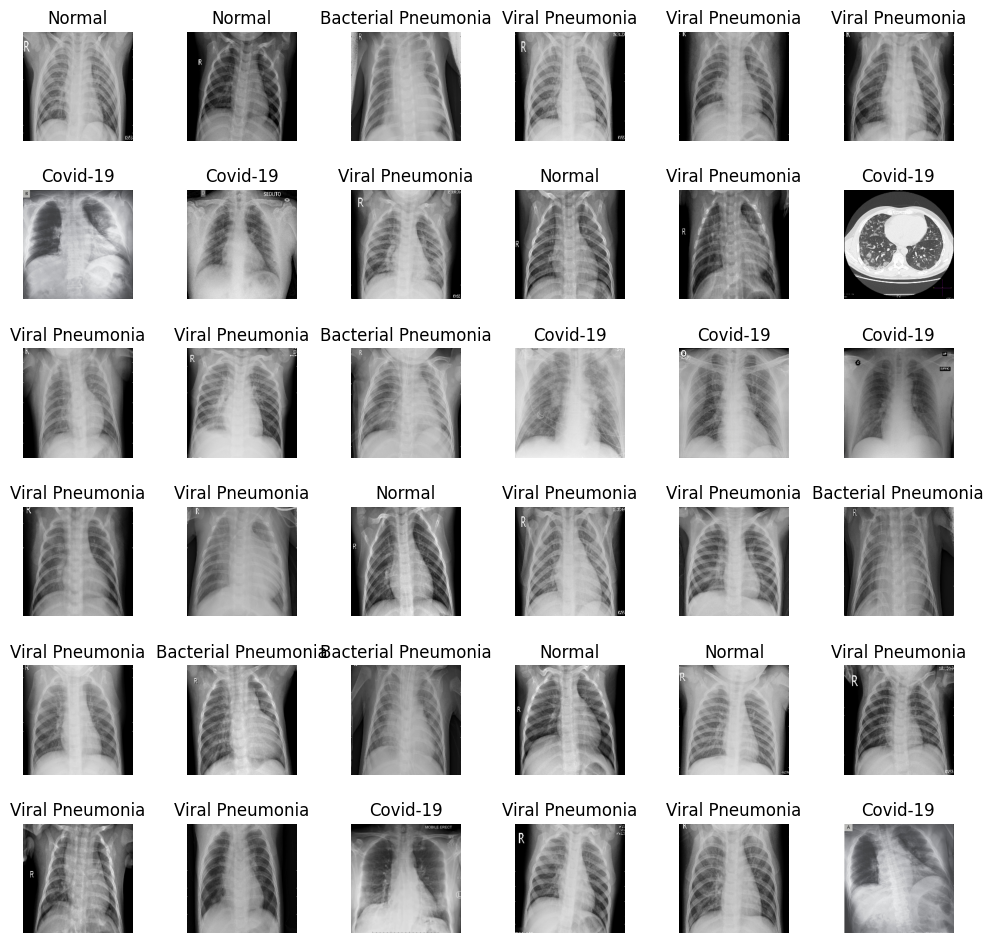

In [14]:
L = 6
W = 6

fig,axes = plt.subplots(L, W , figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# Deep Learning Model

In [15]:
basemodel = ResNet50( weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [26]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten (name = 'flatten') (headmodel)
headmodel = Dense(256, activation = 'relu') (headmodel)
headmodel = Dropout(0.25) (headmodel)
headmodel = Dense(256, activation = 'relu') (headmodel)
headmodel = Dropout(0.25) (headmodel)
headmodel = Dense(4, activation = 'softmax') (headmodel)

In [27]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])


In [29]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
checkpointer = ModelCheckpoint(filepath='weights.keras', verbose=1, save_best_only=True)

In [30]:
train_generator = image_generator.flow_from_directory(batch_size = 4,
                                                      directory = X_Ray_Directory,
                                                      shuffle = True,
                                                      target_size = (256,256),
                                                      class_mode = 'categorical',
                                                      subset = 'training')

validation_generator = image_generator.flow_from_directory(batch_size = 4,
                                                      directory = X_Ray_Directory,
                                                      shuffle = True,
                                                      target_size = (256,256),
                                                      class_mode = 'categorical',
                                                      subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [31]:
history = model.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator,
                    callbacks=[checkpointer, earlystopping])

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8664 - loss: 0.3693
Epoch 1: val_loss improved from inf to 1.39154, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 585s 5s/step - accuracy: 0.8670 - loss: 0.3679 - val_accuracy: 0.6538 - val_loss: 1.3915
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9918 - loss: 0.0334
Epoch 2: val_loss improved from 1.39154 to 0.68359, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - accuracy: 0.9919 - loss: 0.0332 - val_accuracy: 0.7500 - val_loss: 0.6836
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9933 - loss: 0.0224
Epoch 3: val_loss did not improve from 0.68359
107/107 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - accuracy: 0.9933 - loss: 0.0224 - val_accuracy: 0.8942 - val_loss: 0.6918
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9727 - loss: 0.0817
Epoch 4: val_loss did not improve from 0.68359
107/107 ━━━━━━━━━━━━━━━━━━━━ 529s 5s/step - accuracy

#Evaulating the model

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

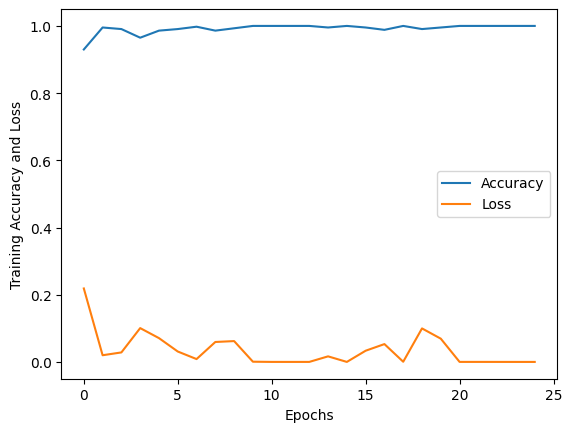

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Accuracy', 'Loss'])
plt.show()

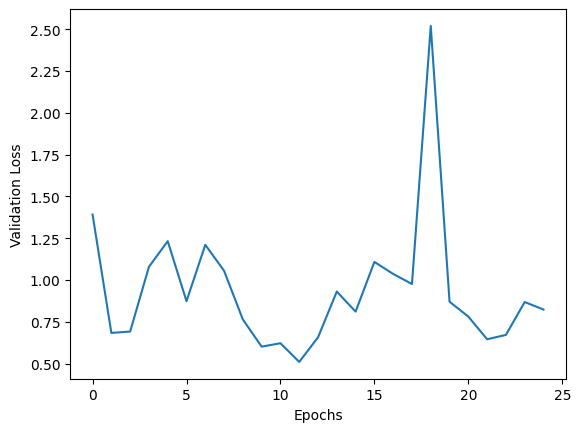

In [36]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

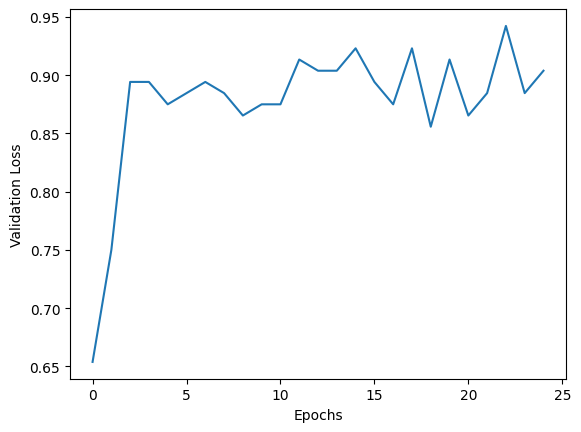

In [38]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

In [39]:
test_directory = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/Data Science for Business Package/4. Operations Department/Data Folder/4. Operations Department/Test'

In [43]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40,
                                              directory = test_directory,
                                              shuffle = True,
                                              target_size = (256, 256),
                                              class_mode = 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose = 1)
print('Accuracy Test : {}'.format(evaluate[1]))


Found 40 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.8250 - loss: 2.1956
Accuracy Test : 0.824999988079071


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img /255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [45]:
socre = accuracy_score(original, prediction)
print('Accuracy Score : {}'.format(socre))

Accuracy Score : 0.8


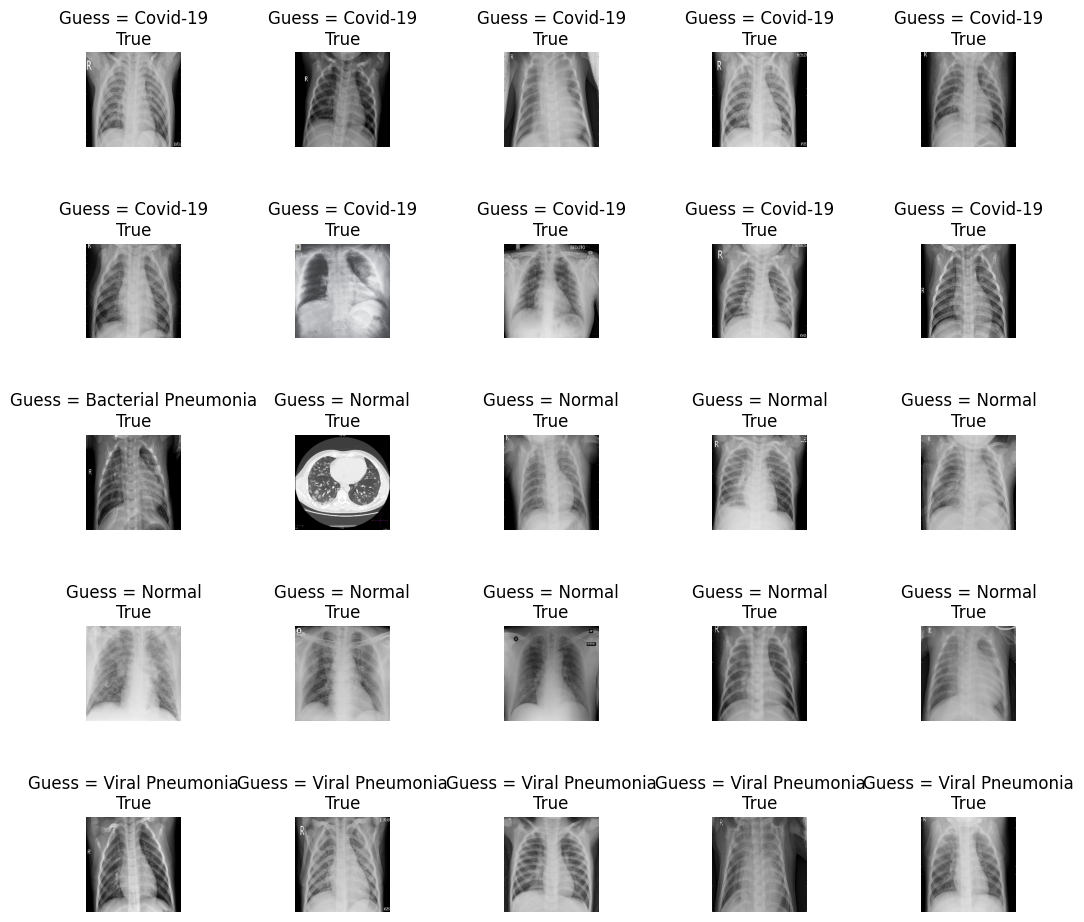

In [47]:
L = 5
W = 5

fig,axes = plt.subplots(L, W , figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title('Guess = {}\nTrue'. format(str(label_names[prediction[i]]), str(label_names[original[i]])))
  axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [48]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.69      0.90      0.78        10
           2       0.86      0.60      0.71        10
           3       0.70      0.70      0.70        10

    accuracy                           0.80        40
   macro avg       0.81      0.80      0.80        40
weighted avg       0.81      0.80      0.80        40



Text(0.5, 1.0, 'Confusion Matrix')

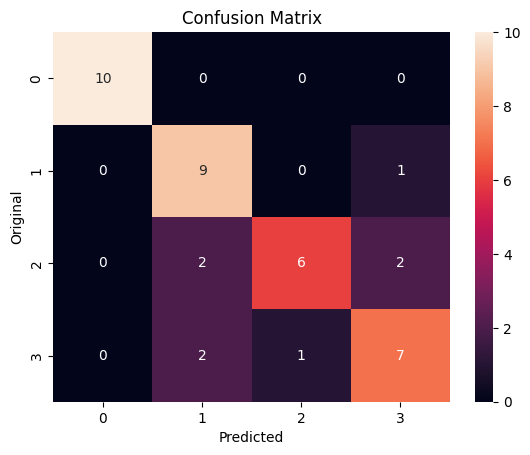

In [49]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax =ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion Matrix')